In [3]:
import torch
import numpy as np
from qtorch_plus.quant import posit_quantize

# Input table
full_table = np.array([6.59179688e-03, 2.19726562e-02, 4.02832031e-02, 6.25000000e-02,
                8.51440430e-02, 2.10937500e-01, 1.21093750e-01, 5.36407471e-01,
                1.56250000e-02, 6.25000000e-02, 1.25000000e-01, 1.64062500e-01,
                2.92968750e-01, 6.25000000e-01, 8.43750000e-01, 4.37500000e-01,
                1.00000000e+00, 2.11486816e+00, 1.50000000e+00, 1.25000000e+00,
                4.25000000e+00, 3.08789062e+00, 8.25000000e+00, 6.00000000e+00])

# Define Posit quantization parameters
nsize = 8  # Number of bits
es = 1     # Exponent size

# Quantize each value in the table
quantized_table = np.array([posit_quantize(torch.tensor(num, dtype=torch.float32), nsize=nsize, es=es, scale=1).item() for num in full_table])

# Print the results
print("Original Table:")
print(full_table)

print("\nQuantized Table (Posit<8,1>):")
print(quantized_table)

# Quantize each value in the table
quantized_table = np.array([posit_quantize(torch.tensor(num, dtype=torch.float32), nsize=nsize, es=es, scale=100).item() for num in full_table])


print("\nQuantized Table (Posit<8,1>) scale = 100:")
print(quantized_table)


Original Table:
[6.59179688e-03 2.19726562e-02 4.02832031e-02 6.25000000e-02
 8.51440430e-02 2.10937500e-01 1.21093750e-01 5.36407471e-01
 1.56250000e-02 6.25000000e-02 1.25000000e-01 1.64062500e-01
 2.92968750e-01 6.25000000e-01 8.43750000e-01 4.37500000e-01
 1.00000000e+00 2.11486816e+00 1.50000000e+00 1.25000000e+00
 4.25000000e+00 3.08789062e+00 8.25000000e+00 6.00000000e+00]

Quantized Table (Posit<8,1>):
[5.859375e-03 2.343750e-02 3.906250e-02 6.250000e-02 8.593750e-02
 2.187500e-01 1.250000e-01 5.312500e-01 1.562500e-02 6.250000e-02
 1.250000e-01 1.562500e-01 2.968750e-01 6.250000e-01 8.437500e-01
 4.375000e-01 1.000000e+00 2.125000e+00 1.500000e+00 1.250000e+00
 4.000000e+00 3.125000e+00 8.000000e+00 6.000000e+00]

Quantized Table (Posit<8,1>) scale = 100:
[6.56249980e-03 2.25000009e-02 3.99999991e-02 5.99999987e-02
 9.00000036e-02 2.00000003e-01 1.19999997e-01 5.60000002e-01
 1.56250000e-02 5.99999987e-02 1.19999997e-01 1.59999996e-01
 2.80000001e-01 6.39999986e-01 9.59999979e

x with max frequency: -2.7230544090270996


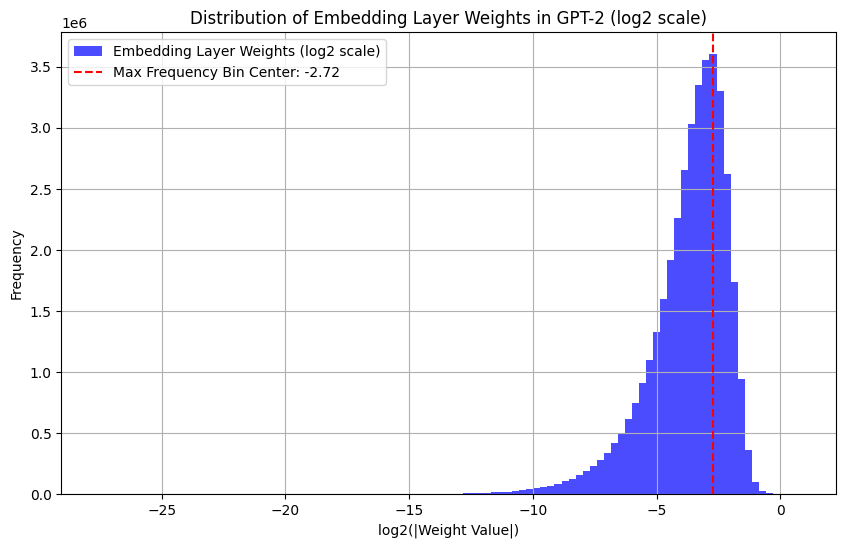

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Extract embedding layer weights
embedding_layer = model.transformer.wte  # Word Token Embedding (wte)
weights = embedding_layer.weight.data.detach().cpu().numpy()

# Flatten the weights into a single array for distribution plotting
weights_flattened = weights.flatten()

# Compute log2 scale for weights (absolute values)
epsilon = 1e-12  # To avoid log(0)
log2_weights = np.log2(np.abs(weights_flattened) + epsilon)

# Compute the histogram and find the bin with maximum frequency
counts, bins = np.histogram(log2_weights, bins=100)
max_bin_index = np.argmax(counts)  # Index of the bin with the highest frequency
x_with_max_frequency = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2  # Bin center

print(f"x with max frequency: {x_with_max_frequency}")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(log2_weights, bins=100, color='blue', alpha=0.7, label="Embedding Layer Weights (log2 scale)")

# Highlight the bin with the maximum frequency
plt.axvline(x=x_with_max_frequency, color='red', linestyle='--', label=f"Max Frequency Bin Center: {x_with_max_frequency:.2f}")

# Add titles and labels
plt.title("Distribution of Embedding Layer Weights in GPT-2 (log2 scale)")
plt.xlabel("log2(|Weight Value|)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

x_with_max_frequency = -2.7230544090270996
Mean Error (Scale=1): 0.0024931547231972218
Mean Error (Scale=-2.72): 0.0013303064042702317


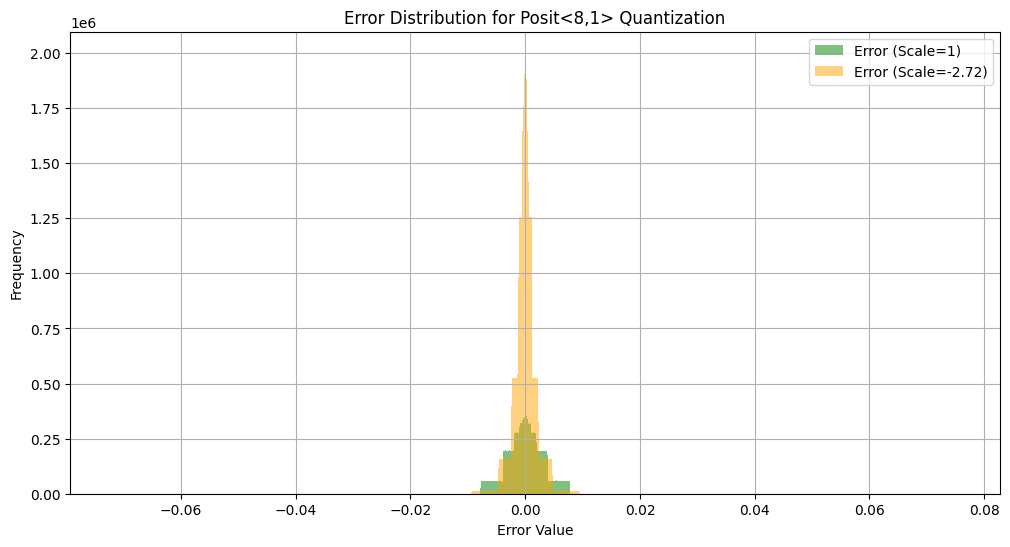

In [ ]:
from qtorch_plus.quant import posit_quantize

# Quantize with scale = 1
quantized_weights_scale_1 = posit_quantize(torch.tensor(weights_flattened, dtype=torch.float32), nsize=8, es=1, scale=1).numpy()
error_scale_1 = weights_flattened - quantized_weights_scale_1
mean_error_scale_1 = np.mean(np.abs(error_scale_1))

# Quantize with scale = x_with_max_frequency
print(f"x_with_max_frequency = {x_with_max_frequency}")
quantized_weights_scale_max = posit_quantize(torch.tensor(weights_flattened, dtype=torch.float32), nsize=8, es=1, scale=2**(-x_with_max_frequency)).numpy()
error_scale_max = weights_flattened - quantized_weights_scale_max
mean_error_scale_max = np.mean(np.abs(error_scale_max))

# Print mean errors
print(f"Mean Error (Scale=1): {mean_error_scale_1}")
print(f"Mean Error (Scale={x_with_max_frequency:.2f}): {mean_error_scale_max}")

# Plot the error distributions
plt.figure(figsize=(12, 6))

# Error distribution for scale = 1
plt.hist(error_scale_1, bins=1000, color='green', alpha=0.5, label="Error (Scale=1)")

# Error distribution for scale = x_with_max_frequency
plt.hist(error_scale_max, bins=1000, color='orange', alpha=0.5, label=f"Error (Scale={x_with_max_frequency:.2f})")

# Add titles and labels
plt.title("Error Distribution for Posit<8,1> Quantization")
plt.xlabel("Error Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# To verify we understand the scaling factor properly
scaling_factor = 2 ** (-x_with_max_frequency)
adjusted_weights = weights_flattened * scaling_factor

quantized_weights_scale_1 = posit_quantize(torch.tensor(adjusted_weights, dtype=torch.float32), nsize=8, es=1, scale=1).numpy()

error_scale_1 = (adjusted_weights - quantized_weights_scale_1)/scaling_factor
mean_error_scale_1 = np.mean(np.abs(error_scale_1))
print(f"Mean Error (Scale=1): {mean_error_scale_1}")

Mean Error (Scale=1): 0.0013303065206855536
